In [32]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.swa_utils import AveragedModel
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim

In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [34]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/home/harshamupparaju/Documents/DL/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

train_images = []
train_labels = []
data_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
for batch in data_batches:
    # Load one batch for demonstration (e.g., data_batch_1)
    batch_dict = load_cifar_batch(os.path.join(cifar10_dir, batch))
    train_images.append(batch_dict[b'data'])
    train_labels.append(batch_dict[b'labels'])

train_images = np.concatenate((train_images[0], train_images[1], train_images[2], train_images[3], train_images[4]))
train_labels = np.concatenate((train_labels[0], train_labels[1], train_labels[2], train_labels[3], train_labels[4]))

# Reshape the images
train_images = train_images.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Load the batch
cifar10_batch = load_cifar_batch('/home/harshamupparaju/Documents/DL/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images 
test_images = cifar10_batch[b'data'].astype(np.float32) / 255.0


validation_data = load_cifar_batch('/home/harshamupparaju/Documents/DL/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch')

validation_images = validation_data[b'data']
validation_labels = validation_data[b'labels']

validation_images = validation_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

train_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomResizedCrop(32, scale=(0.6, 1.0)),  # First, random cropping to increase variation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Small perspective changes
    transforms.RandomRotation(10),  # Small rotations for robustness
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip is common for CIFAR-10
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Small color changes
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.2),  # Not crucial but can keep
    transforms.ToTensor(),  # Convert to tensor (0-1 range)
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalize last
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalize last
])

class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if(self.labels is not None):
            label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        if(self.labels is not None):
            return img, label
        else:
            return img

train_dataset = CustomCIFAR10Dataset(train_images, train_labels, transform=train_transform)
validation_dataset = CustomCIFAR10Dataset(validation_images, validation_labels, transform=test_transform)
test_dataset = CustomCIFAR10Dataset(test_images, transform=test_transform)

trainDataLoader = torch.utils.data.DataLoader(train_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=True)

validationDataLoader = torch.utils.data.DataLoader(validation_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=False)

testDataLoader = torch.utils.data.DataLoader(test_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=False)

In [35]:
data_iter = iter(trainDataLoader)
images, labels = next(data_iter)

# Print the shape and type of the images and labels
print("Shape of images:", images.shape)  # e.g., torch.Size([64, 3, 32, 32])
print("Type of images:", type(images))  # <class 'torch.Tensor'>

print("Shape of labels:", labels.shape)  # e.g., torch.Size([64])
print("Type of labels:", type(labels))  # <class 'torch.Tensor'>

Shape of images: torch.Size([256, 3, 32, 32])
Type of images: <class 'torch.Tensor'>
Shape of labels: torch.Size([256])
Type of labels: <class 'torch.Tensor'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.1308641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.7300353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0985878].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.5351751].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8783362..1.7435488].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.9956021].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.878336

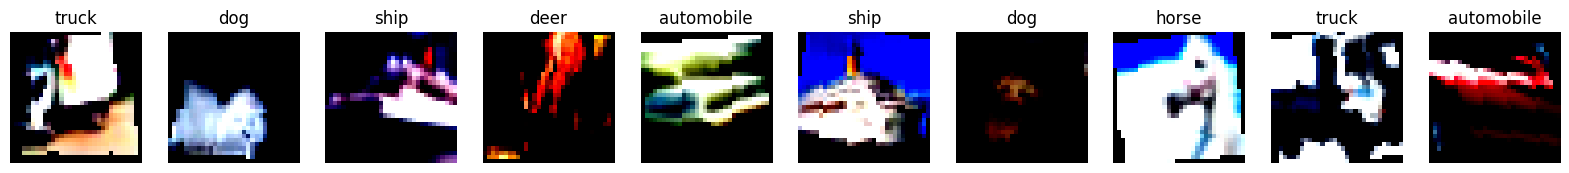

In [36]:
data_iter = iter(trainDataLoader)
images, labels = next(data_iter)


plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i]  # Select one image from the batch
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.title(label_names[labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7830755..2.0985878].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..2.0004883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9259666..2.075614].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4518033..1.8051611].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8783362..1.5660293].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9198096..1.3605304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9735969

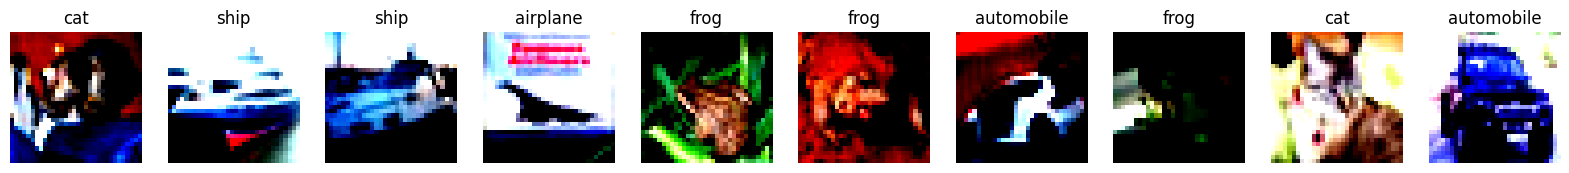

In [37]:
data_iter = iter(validationDataLoader)
images, labels = next(data_iter)


plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i]  # Select one image from the batch
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.title(label_names[labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9843621..1.5797836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.5647584].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9676591..2.1308641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.894213..2.0591094].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.8844646].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8624594..2.0432324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737

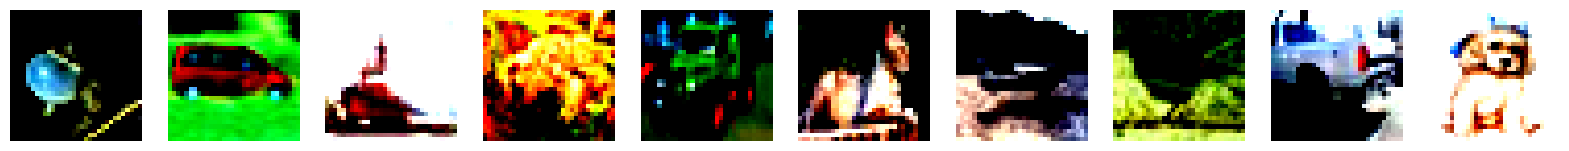

In [38]:
data_iter = iter(testDataLoader)
images = next(data_iter)


plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i]  # Select one image from the batch
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [39]:
class BuildingBlock(nn.Module):

    
    def __init__(self, in_planes, planes, stride=1):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU()

        self.skip = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)  
        out += self.skip(x) 
        out = self.relu2(out)
        return out


class ResNet(nn.Module):
    
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(256, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        layers = [block(self.in_planes, planes, stride)]
        self.in_planes = planes  # Update input channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, stride=1))
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(BuildingBlock, [4, 4, 3])
model = AveragedModel(model)
model = model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
     BuildingBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [42]:
from tqdm import tqdm

loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 80, 90], gamma=0.1)

train_loss_history = []
val_loss_history = []
train_accuracies = []
val_accuracies = []

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
  train_loss = 0.0
  val_loss = 0.0

  correct = 0
  total = 0
  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    predicted = torch.argmax(predicted_output, dim=1)
    correct += (predicted == labels).sum().item()  # Count correct predictions
    total += labels.size(0)  # Total number of samples
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  train_accuracy = 100 * correct / total  # Compute accuracy percentage
  print(f'Train Accuracy: {train_accuracy:.2f}%')

  correct = 0
  total = 0
  model.eval()
  for i, data in enumerate(validationDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      predicted_output = model(images)
      predicted = torch.argmax(predicted_output, dim=1)
      correct += (predicted == labels).sum().item()  # Count correct predictions
      total += labels.size(0)  # Total number of samples
      fit = loss(predicted_output, labels)
      val_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  val_loss = val_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  val_loss_history += [val_loss]
  val_accuracy = 100 * correct / total  # Compute accuracy percentage
  train_accuracies += [train_accuracy]
  val_accuracies += [val_accuracy]
  print(f'Val Accuracy: {val_accuracy:.2f}%')
  print(f'Epoch {epoch}, Train loss {train_loss}, val loss {val_loss}')

  scheduler.step(val_accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

Train Accuracy: 29.02%


/home/harshamupparaju/Softwares/anaconda3/envs/DL/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
  1%|          | 1/100 [05:22<8:52:21, 322.64s/it]

Val Accuracy: 37.76%
Epoch 0, Train loss 1.8815150358239, val loss 1.7436775892972947
Train Accuracy: 42.51%


  2%|▏         | 2/100 [10:51<8:52:36, 326.09s/it]

Val Accuracy: 46.87%
Epoch 1, Train loss 1.5652483458421669, val loss 1.4278207004070282
Train Accuracy: 45.95%


  3%|▎         | 3/100 [16:20<8:49:32, 327.56s/it]

Val Accuracy: 50.50%
Epoch 2, Train loss 1.472395879273512, val loss 1.3397295713424682
Train Accuracy: 49.23%


  4%|▍         | 4/100 [21:54<8:48:17, 330.18s/it]

Val Accuracy: 51.48%
Epoch 3, Train loss 1.3930861840442734, val loss 1.3072938427329064
Train Accuracy: 52.16%


  5%|▌         | 5/100 [27:25<8:43:20, 330.54s/it]

Val Accuracy: 56.64%
Epoch 4, Train loss 1.3141367946352278, val loss 1.1817195624113084
Train Accuracy: 54.91%


  6%|▌         | 6/100 [32:23<8:20:21, 319.38s/it]

Val Accuracy: 58.49%
Epoch 5, Train loss 1.2516092463415496, val loss 1.1220655411481857
Train Accuracy: 57.31%


  7%|▋         | 7/100 [37:21<8:04:18, 312.46s/it]

Val Accuracy: 62.08%
Epoch 6, Train loss 1.1847393731681668, val loss 1.072495274245739
Train Accuracy: 62.32%


  8%|▊         | 8/100 [42:13<7:48:58, 305.85s/it]

Val Accuracy: 66.60%
Epoch 7, Train loss 1.06421006090787, val loss 0.9356912329792977
Train Accuracy: 63.51%


  9%|▉         | 9/100 [47:14<7:41:36, 304.35s/it]

Val Accuracy: 67.48%
Epoch 8, Train loss 1.0324232623893388, val loss 0.9207757130265236
Train Accuracy: 63.90%


 10%|█         | 10/100 [52:09<7:32:01, 301.35s/it]

Val Accuracy: 67.02%
Epoch 9, Train loss 1.019579491140891, val loss 0.9231359720230102
Train Accuracy: 64.68%


 11%|█         | 11/100 [57:09<7:26:45, 301.18s/it]

Val Accuracy: 68.00%
Epoch 10, Train loss 1.0002087296880022, val loss 0.9099332049489022
Train Accuracy: 65.17%


 12%|█▏        | 12/100 [1:02:17<7:24:33, 303.11s/it]

Val Accuracy: 68.57%
Epoch 11, Train loss 0.9878281187646243, val loss 0.8841498345136642
Train Accuracy: 65.54%


 13%|█▎        | 13/100 [1:07:19<7:19:03, 302.80s/it]

Val Accuracy: 68.68%
Epoch 12, Train loss 0.9770278693461905, val loss 0.8833070993423462
Train Accuracy: 66.10%


 14%|█▍        | 14/100 [1:12:15<7:11:08, 300.80s/it]

Val Accuracy: 68.80%
Epoch 13, Train loss 0.9603956791819358, val loss 0.8851088240742684
Train Accuracy: 66.64%


 15%|█▌        | 15/100 [1:17:10<7:03:29, 298.94s/it]

Val Accuracy: 69.74%
Epoch 14, Train loss 0.9483068421178934, val loss 0.8566744938492775
Train Accuracy: 67.01%


 16%|█▌        | 16/100 [1:22:07<6:57:46, 298.41s/it]

Val Accuracy: 70.50%
Epoch 15, Train loss 0.9384255278475431, val loss 0.8401088610291481
Train Accuracy: 67.27%


 17%|█▋        | 17/100 [1:27:04<6:52:02, 297.87s/it]

Val Accuracy: 69.87%
Epoch 16, Train loss 0.9262998885646159, val loss 0.8513989821076393
Train Accuracy: 67.80%


 18%|█▊        | 18/100 [1:32:04<6:48:15, 298.73s/it]

Val Accuracy: 70.88%
Epoch 17, Train loss 0.9146524193335552, val loss 0.8317779868841171
Train Accuracy: 68.32%


 19%|█▉        | 19/100 [1:37:29<6:53:44, 306.48s/it]

Val Accuracy: 71.23%
Epoch 18, Train loss 0.8987272682846809, val loss 0.8284929975867271
Train Accuracy: 68.96%


 20%|██        | 20/100 [1:42:55<6:56:20, 312.26s/it]

Val Accuracy: 71.64%
Epoch 19, Train loss 0.8844643384218216, val loss 0.8085299536585808
Train Accuracy: 69.28%


 21%|██        | 21/100 [1:48:07<6:51:11, 312.30s/it]

Val Accuracy: 71.66%
Epoch 20, Train loss 0.8710682252231909, val loss 0.8082740724086761
Train Accuracy: 69.45%


 22%|██▏       | 22/100 [1:53:03<6:39:25, 307.25s/it]

Val Accuracy: 72.06%
Epoch 21, Train loss 0.8667746639373352, val loss 0.7958008885383606
Train Accuracy: 69.81%


 23%|██▎       | 23/100 [1:58:03<6:31:51, 305.34s/it]

Val Accuracy: 72.22%
Epoch 22, Train loss 0.8555646572186022, val loss 0.8048553228378296
Train Accuracy: 70.36%


 24%|██▍       | 24/100 [2:03:09<6:26:51, 305.42s/it]

Val Accuracy: 72.69%
Epoch 23, Train loss 0.8438548241951027, val loss 0.7835937768220902
Train Accuracy: 70.65%


 25%|██▌       | 25/100 [2:08:12<6:21:01, 304.82s/it]

Val Accuracy: 72.85%
Epoch 24, Train loss 0.8349143403525255, val loss 0.7719442322850227
Train Accuracy: 71.00%


 26%|██▌       | 26/100 [2:13:03<6:10:40, 300.55s/it]

Val Accuracy: 73.89%
Epoch 25, Train loss 0.8188221694863572, val loss 0.755791288614273
Train Accuracy: 71.77%


 27%|██▋       | 27/100 [2:17:47<5:59:34, 295.54s/it]

Val Accuracy: 74.19%
Epoch 26, Train loss 0.8088102206891897, val loss 0.7392908543348312
Train Accuracy: 71.71%


 28%|██▊       | 28/100 [2:22:36<5:52:17, 293.57s/it]

Val Accuracy: 73.42%
Epoch 27, Train loss 0.8026179385428526, val loss 0.7646398469805717
Train Accuracy: 72.12%


 29%|██▉       | 29/100 [2:27:42<5:51:46, 297.28s/it]

Val Accuracy: 74.24%
Epoch 28, Train loss 0.7917047146023536, val loss 0.7395887762308121
Train Accuracy: 72.22%


 30%|███       | 30/100 [2:32:48<5:49:51, 299.88s/it]

Val Accuracy: 73.12%
Epoch 29, Train loss 0.7851015922366357, val loss 0.776340264081955
Train Accuracy: 72.84%


 31%|███       | 31/100 [2:37:38<5:41:30, 296.96s/it]

Val Accuracy: 74.65%
Epoch 30, Train loss 0.7749246924507375, val loss 0.7282750204205513
Train Accuracy: 72.86%


 32%|███▏      | 32/100 [2:42:39<5:37:58, 298.22s/it]

Val Accuracy: 75.55%
Epoch 31, Train loss 0.7704627395284419, val loss 0.7036197379231452
Train Accuracy: 73.27%


 33%|███▎      | 33/100 [2:47:33<5:31:43, 297.07s/it]

Val Accuracy: 75.76%
Epoch 32, Train loss 0.7608334215319886, val loss 0.694567759335041
Train Accuracy: 73.76%


 34%|███▍      | 34/100 [2:52:34<5:27:58, 298.15s/it]

Val Accuracy: 75.12%
Epoch 33, Train loss 0.7503492528078507, val loss 0.6997815564274787
Train Accuracy: 74.02%


 35%|███▌      | 35/100 [2:57:33<5:23:19, 298.46s/it]

Val Accuracy: 76.36%
Epoch 34, Train loss 0.7370342840345538, val loss 0.6813198864459992
Train Accuracy: 74.26%


 36%|███▌      | 36/100 [3:02:21<5:14:53, 295.21s/it]

Val Accuracy: 76.50%
Epoch 35, Train loss 0.7312339085097216, val loss 0.6724498748779297
Train Accuracy: 74.70%


 37%|███▋      | 37/100 [3:07:09<5:07:40, 293.02s/it]

Val Accuracy: 76.22%
Epoch 36, Train loss 0.7281520768087737, val loss 0.681979987025261
Train Accuracy: 75.22%


 38%|███▊      | 38/100 [3:11:57<5:01:23, 291.68s/it]

Val Accuracy: 77.24%
Epoch 37, Train loss 0.7127188964157688, val loss 0.6593897812068462
Train Accuracy: 75.19%


 39%|███▉      | 39/100 [3:16:57<4:59:05, 294.19s/it]

Val Accuracy: 77.12%
Epoch 38, Train loss 0.7080976075055648, val loss 0.66359341442585
Train Accuracy: 75.62%


 40%|████      | 40/100 [3:22:06<4:58:23, 298.38s/it]

Val Accuracy: 76.37%
Epoch 39, Train loss 0.7017472827312897, val loss 0.6878326043486596
Train Accuracy: 75.54%


 41%|████      | 41/100 [3:27:32<5:01:46, 306.88s/it]

Val Accuracy: 75.35%
Epoch 40, Train loss 0.6901489909814329, val loss 0.7301950797438621
Train Accuracy: 75.88%


 42%|████▏     | 42/100 [3:32:57<5:01:44, 312.15s/it]

Val Accuracy: 78.41%
Epoch 41, Train loss 0.6855204344099882, val loss 0.6314858049154282
Train Accuracy: 76.21%


 43%|████▎     | 43/100 [3:38:04<4:55:12, 310.74s/it]

Val Accuracy: 77.95%
Epoch 42, Train loss 0.6755585007521571, val loss 0.6421845898032188
Train Accuracy: 76.84%


 44%|████▍     | 44/100 [3:42:59<4:45:26, 305.84s/it]

Val Accuracy: 78.22%
Epoch 43, Train loss 0.6643523589080694, val loss 0.6268235176801682
Train Accuracy: 76.97%


 45%|████▌     | 45/100 [3:48:03<4:39:55, 305.37s/it]

Val Accuracy: 78.29%
Epoch 44, Train loss 0.6587647342560242, val loss 0.6226622208952903
Train Accuracy: 76.96%


 46%|████▌     | 46/100 [3:53:01<4:32:45, 303.07s/it]

Val Accuracy: 77.45%
Epoch 45, Train loss 0.6578237827943296, val loss 0.6669567316770554
Train Accuracy: 77.71%


 47%|████▋     | 47/100 [3:58:07<4:28:42, 304.19s/it]

Val Accuracy: 78.49%
Epoch 46, Train loss 0.639568607265852, val loss 0.6174241036176682
Train Accuracy: 77.46%


 48%|████▊     | 48/100 [4:03:27<4:27:38, 308.81s/it]

Val Accuracy: 78.61%
Epoch 47, Train loss 0.6403469770234458, val loss 0.6328419104218483
Train Accuracy: 78.15%


 49%|████▉     | 49/100 [4:08:57<4:27:49, 315.10s/it]

Val Accuracy: 78.50%
Epoch 48, Train loss 0.6298787219791996, val loss 0.6080722026526928
Train Accuracy: 78.46%


 50%|█████     | 50/100 [4:14:29<4:26:50, 320.20s/it]

Val Accuracy: 79.33%
Epoch 49, Train loss 0.6186884009108251, val loss 0.5997031576931476
Train Accuracy: 78.49%


 51%|█████     | 51/100 [4:19:55<4:22:53, 321.91s/it]

Val Accuracy: 79.09%
Epoch 50, Train loss 0.6143625197666032, val loss 0.6089386887848377
Train Accuracy: 78.50%


 52%|█████▏    | 52/100 [4:25:13<4:16:41, 320.86s/it]

Val Accuracy: 79.36%
Epoch 51, Train loss 0.6116765225116088, val loss 0.6124000519514083
Train Accuracy: 79.00%


 53%|█████▎    | 53/100 [4:30:28<4:09:54, 319.02s/it]

Val Accuracy: 78.89%
Epoch 52, Train loss 0.6014261998388232, val loss 0.6149531811475754
Train Accuracy: 79.21%


 54%|█████▍    | 54/100 [4:35:23<3:59:02, 311.80s/it]

Val Accuracy: 79.26%
Epoch 53, Train loss 0.5900410105075155, val loss 0.6140682831406593
Train Accuracy: 79.43%


 55%|█████▌    | 55/100 [4:40:21<3:50:53, 307.86s/it]

Val Accuracy: 79.86%
Epoch 54, Train loss 0.5887230970725721, val loss 0.6065051451325416
Train Accuracy: 79.38%


 56%|█████▌    | 56/100 [4:45:19<3:43:29, 304.77s/it]

Val Accuracy: 80.18%
Epoch 55, Train loss 0.5875726847016082, val loss 0.5768412873148918
Train Accuracy: 81.21%


 57%|█████▋    | 57/100 [4:50:23<3:38:15, 304.55s/it]

Val Accuracy: 81.43%
Epoch 56, Train loss 0.5378296658092615, val loss 0.5447442583739758
Train Accuracy: 81.73%


 58%|█████▊    | 58/100 [4:55:29<3:33:31, 305.03s/it]

Val Accuracy: 81.78%
Epoch 57, Train loss 0.5271260090628449, val loss 0.5317400231957435
Train Accuracy: 81.67%


 59%|█████▉    | 59/100 [5:00:28<3:27:07, 303.12s/it]

Val Accuracy: 81.70%
Epoch 58, Train loss 0.5263604971827293, val loss 0.5355839461088181
Train Accuracy: 81.77%


 60%|██████    | 60/100 [5:05:32<3:22:21, 303.53s/it]

Val Accuracy: 81.83%
Epoch 59, Train loss 0.521036436515195, val loss 0.5353532157838344
Train Accuracy: 81.93%


 61%|██████    | 61/100 [5:10:34<3:16:55, 302.96s/it]

Val Accuracy: 81.70%
Epoch 60, Train loss 0.518118636796669, val loss 0.5328174293041229
Train Accuracy: 82.09%


 62%|██████▏   | 62/100 [5:15:22<3:09:07, 298.61s/it]

Val Accuracy: 81.98%
Epoch 61, Train loss 0.5186093162213053, val loss 0.5251256793737411
Train Accuracy: 81.97%


 63%|██████▎   | 63/100 [5:20:10<3:02:03, 295.24s/it]

Val Accuracy: 81.88%
Epoch 62, Train loss 0.5175226409824527, val loss 0.5312838569283486
Train Accuracy: 82.04%


 64%|██████▍   | 64/100 [5:24:56<2:55:31, 292.55s/it]

Val Accuracy: 82.06%
Epoch 63, Train loss 0.5159749227518938, val loss 0.525970283150673
Train Accuracy: 81.90%


 65%|██████▌   | 65/100 [5:29:53<2:51:21, 293.77s/it]

Val Accuracy: 81.83%
Epoch 64, Train loss 0.5159886243696116, val loss 0.5345009371638298
Train Accuracy: 82.01%


 66%|██████▌   | 66/100 [5:34:35<2:44:29, 290.28s/it]

Val Accuracy: 82.12%
Epoch 65, Train loss 0.5137430643852876, val loss 0.5239495307207107
Train Accuracy: 82.15%


 67%|██████▋   | 67/100 [5:39:17<2:38:20, 287.90s/it]

Val Accuracy: 81.86%
Epoch 66, Train loss 0.5115733266789086, val loss 0.5235809028148651
Train Accuracy: 82.13%


 68%|██████▊   | 68/100 [5:44:02<2:33:03, 286.99s/it]

Val Accuracy: 81.82%
Epoch 67, Train loss 0.5081271045670217, val loss 0.53052316904068
Train Accuracy: 82.32%


 69%|██████▉   | 69/100 [5:48:45<2:27:35, 285.66s/it]

Val Accuracy: 81.88%
Epoch 68, Train loss 0.5056136207921165, val loss 0.5287834152579307
Train Accuracy: 82.28%


 70%|███████   | 70/100 [5:53:34<2:23:23, 286.80s/it]

Val Accuracy: 81.98%
Epoch 69, Train loss 0.5073547782946606, val loss 0.5275629192590714
Train Accuracy: 82.26%


 71%|███████   | 71/100 [5:58:17<2:18:07, 285.77s/it]

Val Accuracy: 82.02%
Epoch 70, Train loss 0.5088230041520936, val loss 0.5259307526051998
Train Accuracy: 82.42%


 72%|███████▏  | 72/100 [6:03:05<2:13:39, 286.40s/it]

Val Accuracy: 82.31%
Epoch 71, Train loss 0.5050407380473857, val loss 0.52214035987854
Train Accuracy: 82.75%


 73%|███████▎  | 73/100 [6:07:56<2:09:29, 287.75s/it]

Val Accuracy: 82.28%
Epoch 72, Train loss 0.5006142909429512, val loss 0.5202052101492882
Train Accuracy: 82.65%


 74%|███████▍  | 74/100 [6:12:41<2:04:20, 286.93s/it]

Val Accuracy: 81.99%
Epoch 73, Train loss 0.501361608505249, val loss 0.5234819687902927
Train Accuracy: 82.48%


 75%|███████▌  | 75/100 [6:17:23<1:58:51, 285.27s/it]

Val Accuracy: 82.01%
Epoch 74, Train loss 0.5048384208764348, val loss 0.5258192360401154
Train Accuracy: 82.51%


 76%|███████▌  | 76/100 [6:22:07<1:54:00, 285.03s/it]

Val Accuracy: 82.11%
Epoch 75, Train loss 0.5035890761990937, val loss 0.526052238792181
Train Accuracy: 82.49%


 77%|███████▋  | 77/100 [6:26:49<1:48:56, 284.18s/it]

Val Accuracy: 82.21%
Epoch 76, Train loss 0.5018051414161312, val loss 0.5216934889554977
Train Accuracy: 82.67%


 78%|███████▊  | 78/100 [6:31:31<1:43:53, 283.35s/it]

Val Accuracy: 82.05%
Epoch 77, Train loss 0.49555339238473345, val loss 0.5244653254747391
Train Accuracy: 82.81%


 79%|███████▉  | 79/100 [6:36:14<1:39:09, 283.30s/it]

Val Accuracy: 82.21%
Epoch 78, Train loss 0.4960188537227864, val loss 0.5204953081905842
Train Accuracy: 82.89%


 80%|████████  | 80/100 [6:40:57<1:34:25, 283.29s/it]

Val Accuracy: 81.96%
Epoch 79, Train loss 0.49409981999470265, val loss 0.5296747140586376
Train Accuracy: 82.76%


 81%|████████  | 81/100 [6:45:44<1:30:00, 284.23s/it]

Val Accuracy: 82.19%
Epoch 80, Train loss 0.4965126832224885, val loss 0.5241918124258518
Train Accuracy: 82.70%


 82%|████████▏ | 82/100 [6:50:28<1:25:18, 284.37s/it]

Val Accuracy: 82.15%
Epoch 81, Train loss 0.49816947095856373, val loss 0.5228536635637283
Train Accuracy: 82.71%


 83%|████████▎ | 83/100 [6:55:13<1:20:35, 284.44s/it]

Val Accuracy: 82.23%
Epoch 82, Train loss 0.4957101608113367, val loss 0.521098430454731
Train Accuracy: 82.78%


 84%|████████▍ | 84/100 [6:59:58<1:15:53, 284.61s/it]

Val Accuracy: 82.18%
Epoch 83, Train loss 0.4913736568117628, val loss 0.5228529885411263
Train Accuracy: 83.05%


 85%|████████▌ | 85/100 [7:04:41<1:11:02, 284.15s/it]

Val Accuracy: 82.23%
Epoch 84, Train loss 0.4875759722626939, val loss 0.5223212674260139
Train Accuracy: 83.02%


 86%|████████▌ | 86/100 [7:09:22<1:06:04, 283.16s/it]

Val Accuracy: 82.36%
Epoch 85, Train loss 0.4891517962120017, val loss 0.5177068158984184
Train Accuracy: 83.00%


 87%|████████▋ | 87/100 [7:14:06<1:01:23, 283.35s/it]

Val Accuracy: 82.13%
Epoch 86, Train loss 0.48978323215732766, val loss 0.5226752087473869
Train Accuracy: 82.79%


 88%|████████▊ | 88/100 [7:18:47<56:32, 282.70s/it]  

Val Accuracy: 82.20%
Epoch 87, Train loss 0.4895568255867277, val loss 0.5198769509792328
Train Accuracy: 83.13%


 89%|████████▉ | 89/100 [7:23:26<51:39, 281.73s/it]

Val Accuracy: 82.41%
Epoch 88, Train loss 0.4867538251743025, val loss 0.5183255083858966
Train Accuracy: 83.02%


 90%|█████████ | 90/100 [7:28:07<46:53, 281.34s/it]

Val Accuracy: 82.37%
Epoch 89, Train loss 0.487875334006183, val loss 0.5211046621203422
Train Accuracy: 83.17%


 91%|█████████ | 91/100 [7:32:47<42:08, 280.98s/it]

Val Accuracy: 82.22%
Epoch 90, Train loss 0.48614124071841336, val loss 0.5256253205239773
Train Accuracy: 83.02%


 92%|█████████▏| 92/100 [7:37:26<37:24, 280.57s/it]

Val Accuracy: 82.28%
Epoch 91, Train loss 0.4872343257373693, val loss 0.5189677827060223
Train Accuracy: 83.24%


 93%|█████████▎| 93/100 [7:42:07<32:43, 280.46s/it]

Val Accuracy: 82.19%
Epoch 92, Train loss 0.4795941293847804, val loss 0.5225273691117763
Train Accuracy: 83.18%


 94%|█████████▍| 94/100 [7:46:47<28:02, 280.37s/it]

Val Accuracy: 82.31%
Epoch 93, Train loss 0.48577283018705797, val loss 0.5187766559422016
Train Accuracy: 83.25%


 95%|█████████▌| 95/100 [7:51:25<23:18, 279.71s/it]

Val Accuracy: 82.56%
Epoch 94, Train loss 0.4801522494882953, val loss 0.5156999409198761
Train Accuracy: 83.29%


 96%|█████████▌| 96/100 [7:56:06<18:40, 280.14s/it]

Val Accuracy: 82.42%
Epoch 95, Train loss 0.4772642335417319, val loss 0.5159529589116574
Train Accuracy: 83.43%


 97%|█████████▋| 97/100 [8:00:47<14:01, 280.48s/it]

Val Accuracy: 82.20%
Epoch 96, Train loss 0.4794422743880019, val loss 0.5216738373041153
Train Accuracy: 83.55%


 98%|█████████▊| 98/100 [8:05:27<09:20, 280.24s/it]

Val Accuracy: 82.46%
Epoch 97, Train loss 0.47455624582207934, val loss 0.519624899327755
Train Accuracy: 83.43%


 99%|█████████▉| 99/100 [8:10:06<04:39, 279.79s/it]

Val Accuracy: 82.53%
Epoch 98, Train loss 0.4777411780491167, val loss 0.5135033935308456
Train Accuracy: 83.19%


100%|██████████| 100/100 [8:14:48<00:00, 296.88s/it]

Val Accuracy: 82.57%
Epoch 99, Train loss 0.48030822754514463, val loss 0.5177564524114132


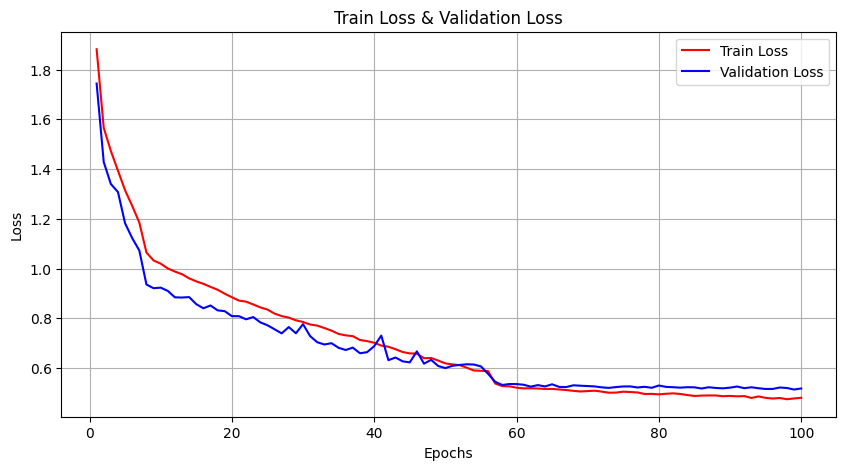

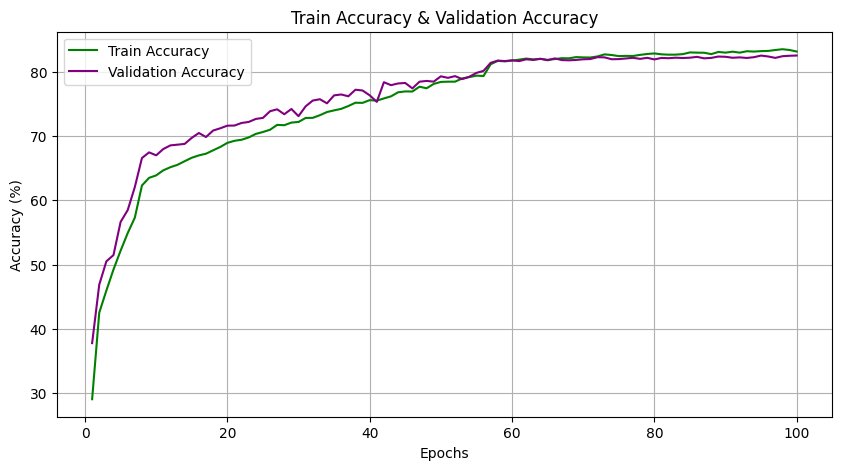

In [44]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss', color='red')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss & Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train Accuracy & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [46]:
model.eval()
predictions = []
with torch.no_grad():
    for images in testDataLoader:
        images = images.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/home/harshamupparaju/Documents/DL/Cifar_10_Image_Classification/submission.csv', index=False)
print("Submission file saved.")

Submission file saved.


In [47]:
torch.save(model.state_dict(), "model_weights.pth")

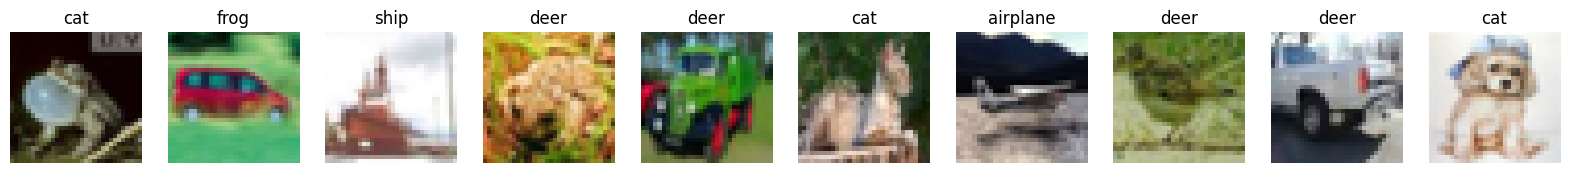

In [48]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    images = torch.tensor(test_images[i], dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
    images = images.permute(2, 0, 1).unsqueeze(0).to(device)  # Add batch dimension and move to device
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1).item()  # Extract the prediction
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_images[i])  # Original image format for visualization
    plt.title(label_names[predicted].decode('utf-8'))  # Show predicted label as title
    plt.axis('off')

plt.show()